First, complete the code for the number game following the instructions in the comments below. Note that here we are considering a specific hypothesis space that is slightly different from the one shown in the lecture.

In [179]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr 

In [180]:
def number_game_priors(N, math_prior, interval_prior):
    """Generaten all hypotheses and compute their priors
        Input:
            N: the total number (100 in our case)
            math_prior, interval_prior: 
                priors for math properties and interval (raw magnitudes)
                hypothesis types respectively
        
        Return:
            hypotheses: all hypotheses, a matrix with each column representing a specific hypothesis
                each hypothesis is a logical (0 or 1) vector on N elements, where
                hypothesis[i] = 1 iff i is contained in the extension of the
                concept represented by hypothesis.
        
            priors: priors of all hypotheses
    """

    if abs((math_prior + interval_prior) - 1) > 0.05:
        raise ValueError('Sum of all priors should be 1!')

    hypotheses = np.zeros((0, N))
    vals = np.arange(N) + 1
    
    #################
    # math properties
    #################
    
    # odds 1
    concept = np.equal(np.mod(vals, 2), 1).astype(int)
    hypotheses = np.vstack([hypotheses, concept]) #vstack didn't work so changed
    
    # square, cube
    roots = [2, 3]
    for r in roots:
        root = np.power(vals, 1/r)
        concept = np.equal(np.floor(root), root).astype(int)
        hypotheses = np.vstack([hypotheses, concept])
    
    # multiples of 2 to 12
    for mult in range(2, 13):
        concept = np.equal(np.mod(vals, mult), 0).astype(int)
        hypotheses = np.vstack([hypotheses, concept])
    
    # powers of 2 to 12
    for pow in range(2, 13):
        base = np.emath.logn(pow, vals)
        concept = np.equal(np.floor(base), base).astype(int)
        hypotheses = np.vstack([hypotheses, concept])

    # prime numbers
    def is_prime(n):
        for i in range(2, int(np.sqrt(n) + 1)):
            if (n % i) == 0:
                return False
        return True
    
    is_prime_vectorized = np.vectorize(is_prime)
    
    hypotheses = np.vstack([hypotheses, is_prime_vectorized(vals)])
    
    ###########
    # intervals
    ###########
    len_math = hypotheses.shape[0] # record length of math hypothesis before adding intervals
    
    for begin in range(1, N):
        for size in range(1, N + 1):
            if size + begin > N: continue
            else: 
                interval = np.zeros(N)
                interval[begin:begin+size] = 1
                hypotheses = np.vstack([hypotheses, interval])
    
    len_interval = hypotheses.shape[0] - len_math
    #############################
    # compute prior probabilities
    #############################
    priors = np.empty(hypotheses.shape[0])
    priors[:len_math] = math_prior / len_math
    priors[len_math:] = interval_prior / len_interval
    
    return hypotheses, priors

In [181]:
def number_game_likelihood(hypothesis, data):
    """Compute the likelihood
        Input:
            hypothesis: a logical (0 or 1) vector on N elements, where
                hypothesis[i] = 1 if i is contained in the extension of the
                concept represented by hypothesis.

            data: similarly, a logical vector where data[i] = 1 if
                i is contained in the observed dataset.

            note that length(hypothesis) == length(data) unless the caller
            of this procedure messed up
    
        Return:
            likelihood: P(data | hypothesis)
        
        TODO: first check if data is consistent with the given hypothesis.

        if it isn't, P(D|H) = 0.

        TODO: under strong sampling WITH REPLACEMENT, every consistent hypothesis
        assigns probability 1/(#options) to each data draw.
    """
    assert len(hypothesis) == len(data), "length of hypothesis not consistent with data" # check if called messed up
    
    if np.any((data == 1) & (hypothesis == 0)):
        return 0
    
    size_h = np.sum(hypothesis)
    n = np.sum(data)

    return (1/size_h) ** n

In [182]:
def number_game_posteriors(hypotheses, priors, data):
    """Compute the posteriors
        Input:
            hypotheses: a matrix whose columns are particular hypotheses,
                represented as logical vectors reflecting datapoint membership

            priors: a vector of prior probabilities for each hypothesis

            data: a vector of observed numbers
            
        Return:
            posteriors: an array with k-th element indicating the posterior of the k-th hypothesis in hypotheses
    """

    def numbers_to_logical(data):
        if np.isscalar(data): data = [data]
        logical_data = np.zeros(N)
        for datum in data:
            logical_data[datum-1] = 1
        return logical_data

    hyps, N = hypotheses.shape
    logical_data = numbers_to_logical(data)
        
    # compute the posterior for every hypothesis
    posteriors = np.zeros(hyps)
    
    for i in range(hyps):
        posteriors[i] = number_game_likelihood(hypotheses[i], logical_data) * priors[i]
    
    return posteriors /= np.sum(posteriors)

In [183]:
def number_game_predictions(posteriors, hypotheses):
    """Predict the possible numbers
        Input:
            posteriors: an array with k-th element indicating the posterior of the k-th hypothesis in hypotheses
            
            hypotheses: a matrix whose rows are particular hypotheses,
                represented as logical vectors reflecting datapoint membership
            
        Return:
            predictive: an N-dim array; k-th element is the probability of the number k+1 fitting the concept 
    """
    
    return posteriors @ hypotheses

In [184]:
def number_game_plot_predictions(data, N, math_prior, interval_prior):
    """Main function -- given data and hyperparameters,
            infer the concept,
            predict numbers that fit the concept,
            and compare model predictions with human resposes
            
        Input:
            data: a vector of observed numbers
            
            N: max number (we only consider 1..N)
            
            math_prior ad interval_prior: 
                priors for math properties and intervals (raw magnitude)
                hypothesis types respectively
    """    
    
    # compute all hypotheses and their priors based on the hyperparameters
    hypotheses, priors = number_game_priors(N, math_prior, interval_prior)

    posteriors = number_game_posteriors(hypotheses, priors, data)

    # compute the predictive contribution for each
    # hypothesis and add it in to the predictive
    predictive = number_game_predictions(posteriors, hypotheses)

    # plot it as a bar chart, also plot human data
    # and the top 3 hypotheses in decreasing order of posterior
    # probability

    fig, ax = plt.subplots(5,1, figsize=(7, 7))
    fig.subplots_adjust(top=0.95, bottom=0.05, hspace=0.85,
        left=0.05, right=0.95)
    
    #read human responses (numbers humans were asked to judge and the corresponding average responses)
    dataset = "[{}]".format(",".join([str(d) for d in data]))
    numbers, judgments = np.genfromtxt('./data/csv/' + dataset + '.csv', delimiter=',').T
    
    probabilities_human = np.zeros(N)
    for i in range(numbers.size):
        probabilities_human[int(numbers[i])-1] = judgments[i]

    probabilities_model = np.zeros(N)
    for i in range(numbers.size):
        probabilities_model[int(numbers[i])-1] = predictive[int(numbers[i])-1]
        
    #compute the correlation between model predictions and human predictions
    print('correlation:', pearsonr(probabilities_model, probabilities_human)[0])
        
    ax[0].bar(np.arange(N)+1.0, probabilities_model, 0.5, color='k')
    if np.isscalar(data): data = [data]
    ax[0].set_title('Predictions given observation(s) %s'
        % ', '.join(str(d) for d in data))
    ax[0].set_xlim([-0.5, (N+1)+0.5])
    ax[0].set_ylim([-0.05, 1.05])

    # plot the human data
    ax[1].bar(np.arange(N)+1.0, probabilities_human, 0.5, color='k')
    ax[1].set_title('Human predictive probabilities')
    ax[1].set_xlim([-0.5, (N+1)+0.5])
    ax[1].set_ylim([-0.05, 1.05])

    sort_indices = np.argsort(posteriors)[::-1]

    topN = 3
    for i in range(2, 2+topN):
        hypo_index = sort_indices[i-2]
        ax[i].bar(np.arange(N)+1.0, hypotheses[hypo_index,:], 0.5, color='k')
        ax[i].set_xlim([-0.5, (N+1)+0.5])
        ax[i].set_ylim([-0.05, 1.05])

        # only consider hypotheses with probability greater 0
        if posteriors[hypo_index] == 0.0:
            ax[i].set_visible(False)
            topN -= 1
    ax[2].set_title('Top %u hypotheses in descending order of posterior probability' % topN)
    plt.show()

For each set of observed numbers, compute the correlation between model predictions and human predictions, plot model & human predictions, and show the top 3 hypoteheses. Note that a reasonable model should give you high correlation between model predictions and human predictions (> 0.95 for each example set). You can play around the hypotheses space (adding new hypotheses or removing hypotheses) as well as the hyperparameters and discuss how priors can affect the model's ability to approxmiate human predictions. 

correlation: 0.96788460557633


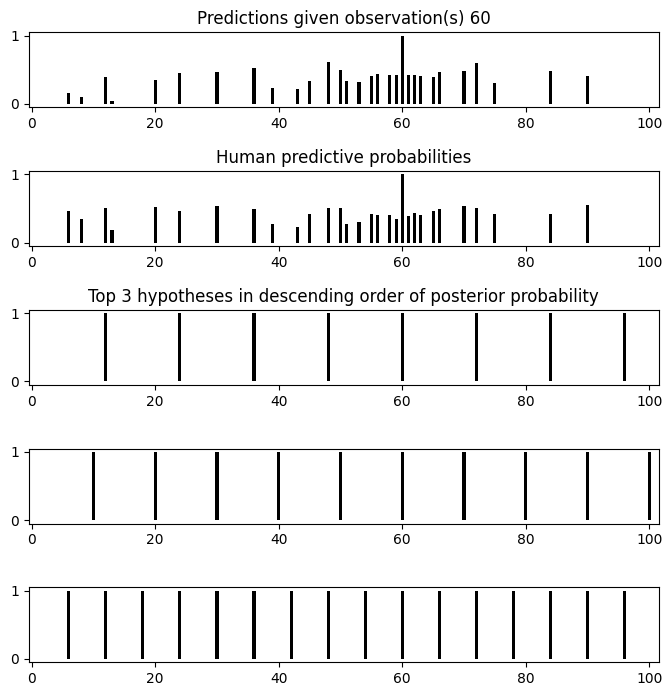

In [185]:
math_prior, interval_prior = 0.5, 0.5
number_game_plot_predictions([60], 100, math_prior, interval_prior)

correlation: 0.9727624236753023


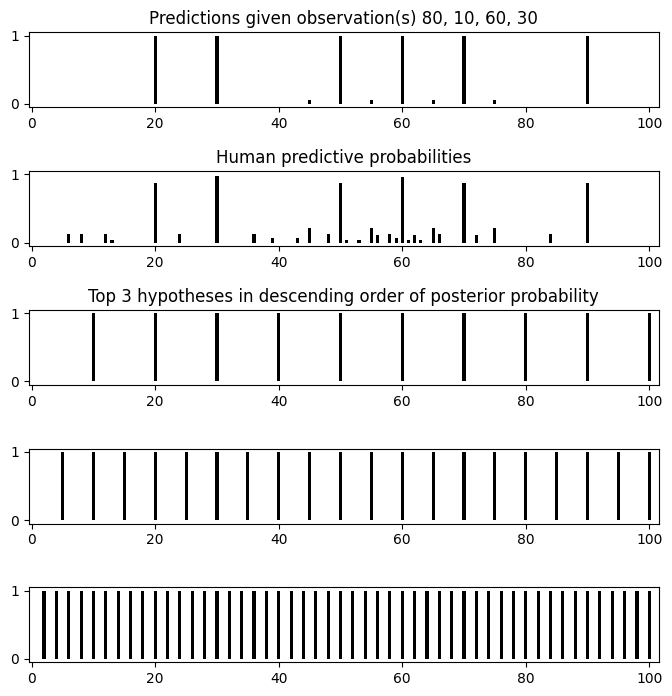

In [186]:
number_game_plot_predictions([80,10,60,30], 100, math_prior, interval_prior)

correlation: 0.9777847090583408


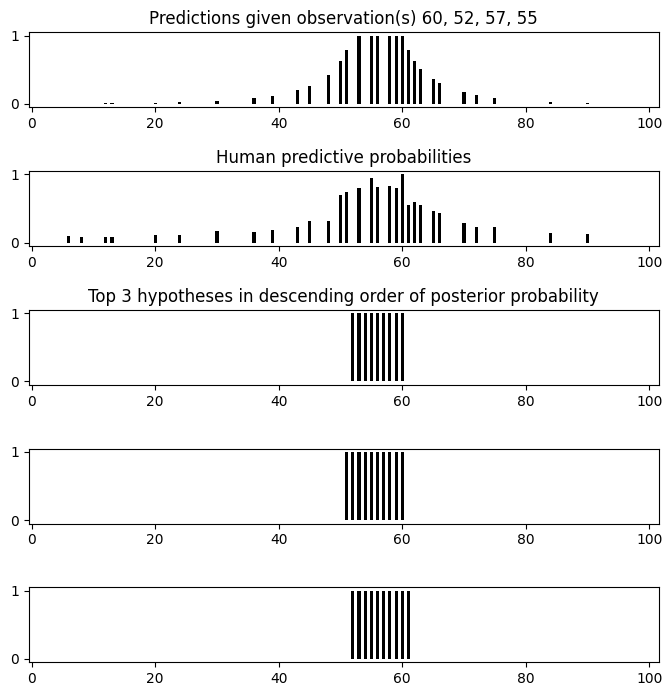

In [187]:
number_game_plot_predictions([60,52,57,55], 100, math_prior, interval_prior)

correlation: 0.9755173170892022


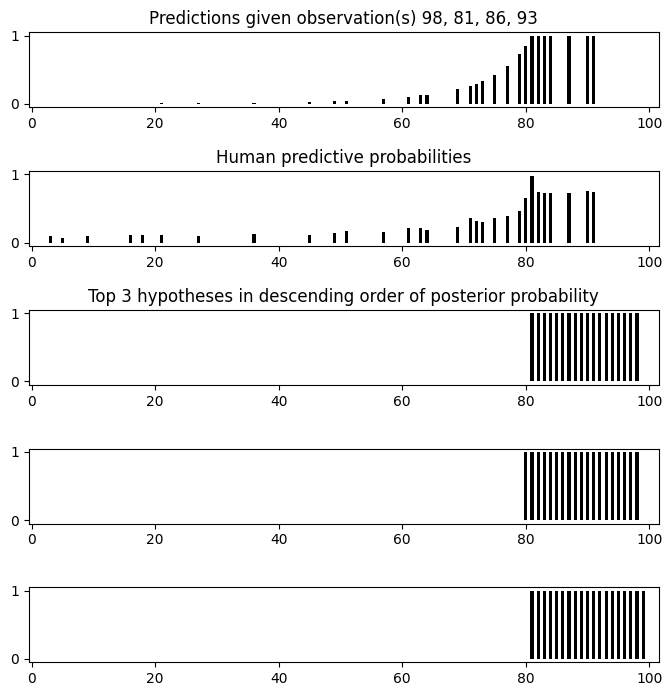

In [188]:
number_game_plot_predictions([98,81,86,93], 100, math_prior, interval_prior)